In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Detected Classes: ['without_mask', 'with_mask']
without_mask: 3828 images
with_mask: 3725 images


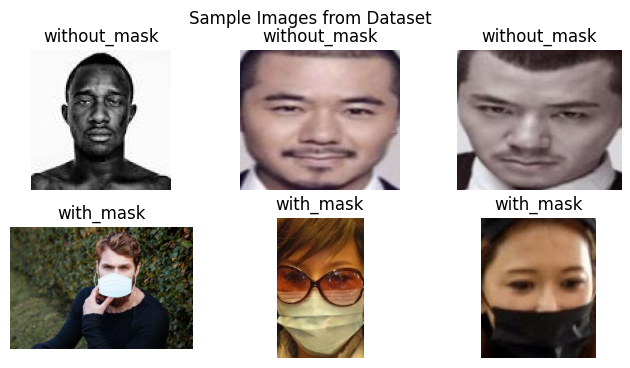

In [3]:
# Dataset structure required:
# data/
#     with_mask/
#     without_mask/

# DATASET PATH & INITIAL CHECK

dataset_dir = "data/"  # main folder containing two classes

classes = os.listdir(dataset_dir)
print("Detected Classes:", classes)

# Count number of images per class
for cls in classes:
    class_path = os.path.join(dataset_dir, cls)
    print(f"{cls}: {len(os.listdir(class_path))} images")

# Visualize sample images (3 samples per class if available)
plt.figure(figsize=(8,4))
idx = 1
for cls in classes:
    class_path = os.path.join(dataset_dir, cls)
    sample_images = os.listdir(class_path)[:3]  # take first 3
    for img in sample_images:
        img_path = os.path.join(class_path, img)
        img_data = plt.imread(img_path)
        plt.subplot(2, 3, idx)
        plt.imshow(img_data)
        plt.title(cls)
        plt.axis('off')
        idx += 1
plt.suptitle("Sample Images from Dataset")
plt.show()

In [4]:
# IMAGE PREPROCESSING & DATA LOADING
# We use ImageDataGenerator for augmentation + validation split

img_size = 128
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,    # 20% for validation
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',     # binary labels (0/1)
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

print("Class Mapping:", train_generator.class_indices)


Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.
Class Mapping: {'with_mask': 0, 'without_mask': 1}


In [5]:
# 3. BUILDING THE CNN MODEL
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')   # output neuron for binary classification
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


C:\Users\Administrator\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# 4. CALLBACKS (SAVE BEST MODEL + EARLY STOPPING)
checkpoint = ModelCheckpoint(
    "mask_detector_model_2.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    verbose=1
)


In [7]:
# 5. TRAINING THE MODEL
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/20
 78/189 ━━━━━━━━━━━━━━━━━━━━ 1:23 750ms/step - accuracy: 0.5804 - loss: 0.6830

C:\Users\Administrator\AppData\Roaming\Python\Python313\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.6640 - loss: 0.6000
Epoch 1: val_accuracy improved from None to 0.85232, saving model to mask_detector_model_2.h5



Epoch 1: finished saving model to mask_detector_model_2.h5
189/189 ━━━━━━━━━━━━━━━━━━━━ 179s 941ms/step - accuracy: 0.7574 - loss: 0.4973 - val_accuracy: 0.8523 - val_loss: 0.3614
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8285 - loss: 0.3947
Epoch 2: val_accuracy improved from 0.85232 to 0.88609, saving model to mask_detector_model_2.h5



Epoch 2: finished saving model to mask_detector_model_2.h5
189/189 ━━━━━━━━━━━━━━━━━━━━ 38s 201ms/step - accuracy: 0.8284 - loss: 0.3904 - val_accuracy: 0.8861 - val_loss: 0.2913
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8578 - loss: 0.3312
Epoch 3: val_accuracy improved from 0.88609 to 0.89868, saving model to mask_detector_model_2.h5



Epoch 3: finished saving model to mask_detector_model_2.h5
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 209ms/step - accuracy: 0.8633 - loss: 0.3294 - val_accuracy: 0.8987 - val_loss: 0.2636
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8772 - loss: 0.3074
Epoch 4: val_accuracy improved from 0.89868 to 0.90066, saving model to mask_detector_model_2.h5



Epoch 4: finished saving model to mask_detector_model_2.h5
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 214ms/step - accuracy: 0.8850 - loss: 0.2980 - val_accuracy: 0.9007 - val_loss: 0.2484
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9027 - loss: 0.2587
Epoch 5: val_accuracy improved from 0.90066 to 0.90530, saving model to mask_detector_model_2.h5



Epoch 5: finished saving model to mask_detector_model_2.h5
189/189 ━━━━━━━━━━━━━━━━━━━━ 39s 206ms/step - accuracy: 0.9052 - loss: 0.2593 - val_accuracy: 0.9053 - val_loss: 0.2440
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9026 - loss: 0.2504
Epoch 6: val_accuracy improved from 0.90530 to 0.91589, saving model to mask_detector_model_2.h5



Epoch 6: finished saving model to mask_detector_model_2.h5
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 209ms/step - accuracy: 0.9053 - loss: 0.2409 - val_accuracy: 0.9159 - val_loss: 0.2244
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9103 - loss: 0.2389
Epoch 7: val_accuracy improved from 0.91589 to 0.92583, saving model to mask_detector_model_2.h5



Epoch 7: finished saving model to mask_detector_model_2.h5
189/189 ━━━━━━━━━━━━━━━━━━━━ 39s 207ms/step - accuracy: 0.9128 - loss: 0.2332 - val_accuracy: 0.9258 - val_loss: 0.2087
Epoch 8/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9145 - loss: 0.2315
Epoch 8: val_accuracy improved from 0.92583 to 0.93709, saving model to mask_detector_model_2.h5



Epoch 8: finished saving model to mask_detector_model_2.h5
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 211ms/step - accuracy: 0.9199 - loss: 0.2175 - val_accuracy: 0.9371 - val_loss: 0.1729
Epoch 9/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9262 - loss: 0.1901
Epoch 9: val_accuracy did not improve from 0.93709
189/189 ━━━━━━━━━━━━━━━━━━━━ 39s 207ms/step - accuracy: 0.9275 - loss: 0.1845 - val_accuracy: 0.9358 - val_loss: 0.1733
Epoch 10/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9388 - loss: 0.1789
Epoch 10: val_accuracy did not improve from 0.93709
189/189 ━━━━━━━━━━━━━━━━━━━━ 39s 208ms/step - accuracy: 0.9336 - loss: 0.1819 - val_accuracy: 0.9318 - val_loss: 0.2011
Epoch 11/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9384 - loss: 0.1694
Epoch 11: val_accuracy did not improve from 0.93709
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 211ms/step - accuracy: 0.9411 - loss: 0.1595 - val_accuracy: 0.9364 - val_loss: 0.1810
Epoch 12/20
189/189 ━━━━━━━━━━━━━━━━━━━


Epoch 13: finished saving model to mask_detector_model_2.h5
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 231ms/step - accuracy: 0.9429 - loss: 0.1553 - val_accuracy: 0.9543 - val_loss: 0.1371
Epoch 14/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9491 - loss: 0.1443
Epoch 14: val_accuracy did not improve from 0.95430
189/189 ━━━━━━━━━━━━━━━━━━━━ 42s 220ms/step - accuracy: 0.9509 - loss: 0.1439 - val_accuracy: 0.9483 - val_loss: 0.1469
Epoch 15/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9492 - loss: 0.1389
Epoch 15: val_accuracy did not improve from 0.95430
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - accuracy: 0.9477 - loss: 0.1445 - val_accuracy: 0.9411 - val_loss: 0.1522
Epoch 16/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9479 - loss: 0.1373
Epoch 16: val_accuracy did not improve from 0.95430
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - accuracy: 0.9528 - loss: 0.1303 - val_accuracy: 0.9503 - val_loss: 0.1327
Epoch 17/20
189/189 ━━━━━━━━━━━━━━━━


Epoch 17: finished saving model to mask_detector_model_2.h5
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 214ms/step - accuracy: 0.9538 - loss: 0.1204 - val_accuracy: 0.9636 - val_loss: 0.1136
Epoch 18/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9543 - loss: 0.1209
Epoch 18: val_accuracy did not improve from 0.96358
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 214ms/step - accuracy: 0.9537 - loss: 0.1235 - val_accuracy: 0.9457 - val_loss: 0.1359
Epoch 19/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9536 - loss: 0.1283
Epoch 19: val_accuracy did not improve from 0.96358
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 212ms/step - accuracy: 0.9547 - loss: 0.1285 - val_accuracy: 0.9503 - val_loss: 0.1354
Epoch 20/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9586 - loss: 0.1146
Epoch 20: val_accuracy improved from 0.96358 to 0.96490, saving model to mask_detector_model_2.h5



Epoch 20: finished saving model to mask_detector_model_2.h5
189/189 ━━━━━━━━━━━━━━━━━━━━ 42s 224ms/step - accuracy: 0.9590 - loss: 0.1178 - val_accuracy: 0.9649 - val_loss: 0.1080


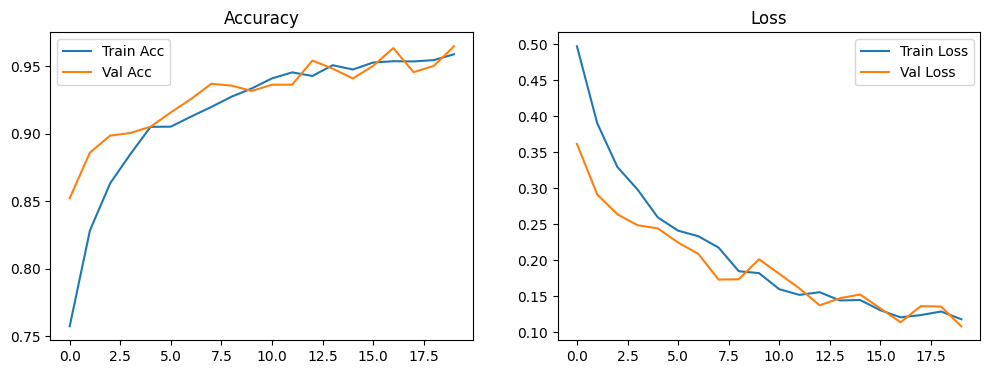

In [8]:
# TRAINING PERFORMANCE PLOT

plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.show()

In [9]:
# PREDICTION ON NEW IMAGES
from tensorflow.keras.preprocessing import image

def predict_mask(img_path):
    """
    Predict whether a person is wearing mask or not from image path.
    """
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)[0][0]

    if prediction > 0.5:
        print("Prediction: WITHOUT MASK")
    else:
        print("Prediction: WITH MASK")

# Usage Example:
predict_mask("data\without_mask\without_mask_10.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

<>:20: SyntaxWarning: invalid escape sequence '\w'
<>:20: SyntaxWarning: invalid escape sequence '\w'
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13140\2387316066.py:20: SyntaxWarning: invalid escape sequence '\w'
  predict_mask("data\without_mask\without_mask_10.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Prediction: WITHOUT MASK


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction: WITHOUT MASK


<>:33: SyntaxWarning: invalid escape sequence '\w'
<>:33: SyntaxWarning: invalid escape sequence '\w'
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13140\909822665.py:33: SyntaxWarning: invalid escape sequence '\w'
  predict_mask("data\without_mask\without_mask_10.jpg")


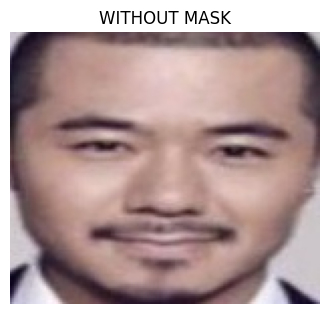

In [10]:

# PREDICTION ON NEW IMAGES (with displayed label)

from tensorflow.keras.preprocessing import image

def predict_mask(img_path):
    """
    Predict whether a person is wearing mask or not from image path.
    Displays the image + result label.
    """
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)[0][0]

    # Determine label
    if prediction > 0.5:
        label = "WITHOUT MASK"
    else:
        label = "WITH MASK"

    # Print prediction
    print("Prediction:", label)

    # Display image + text
    plt.figure(figsize=(4,4))
    plt.imshow(image.load_img(img_path))
    plt.title(label, fontsize=12)  # small label
    plt.axis('off')
    plt.show()

# Usage Example:
predict_mask("data\without_mask\without_mask_10.jpg")
